In [1]:
#x01_populationStatistics

In [3]:
# from chewc.callback import *
from chewc.policy import *
from chewc.sim import *
from chewc.lab import *
from chewc.config import *
from chewc.utils import *


import matplotlib.pyplot as plt
import uuid
import pdb
import torch
import torch
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter



from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList

In [4]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class CurriculumCallback(BaseCallback):
    def __init__(self, start_gen, end_gen, curriculum_steps, verbose=0):
        super(CurriculumCallback, self).__init__(verbose)
        self.start_gen = start_gen
        self.end_gen = end_gen
        self.curriculum_steps = curriculum_steps
        self.current_max_gen = start_gen

    def _on_step(self) -> bool:
        progress = min(1.0, self.n_calls / self.curriculum_steps)
        new_max_gen = int(self.start_gen + progress * (self.end_gen - self.start_gen))
        
        if new_max_gen > self.current_max_gen:
            self.current_max_gen = new_max_gen
            self.training_env.env_method("update_max_generations", new_max_gen)
            
            if self.verbose > 0:
                print(f"Updating max_generations to {new_max_gen}")
        
        return True

In [5]:
config = get_default_config()
config['n_parents'] = 5
config['n_loci'] = 100
config['pop_size'] = 100
config['total_timesteps'] = 2048*1
config['start_gen'] = 2
config['end_gen'] = 10
config['seed'] = 4
config['sparse_reward'] = True
config['h2'] = 1

for i in config:
    print(f"{i} : {config[i]}")

observation_config : {'remaining_proportion': {'type': 'scalar', 'low': 0, 'high': 1}, 'genetic_variance': {'type': 'scalar', 'low': 0, 'high': inf}, 'mean_phenotype': {'type': 'scalar', 'low': -inf, 'high': inf}, 'max_breeding_value': {'type': 'scalar', 'low': -inf, 'high': inf}}
start_gen : 2
end_gen : 10
curriculum_steps : 100000
action_low : 0.01
action_high : 0.99
sparse_reward : True
n_parents : 5
n_chr : 1
n_loci : 100
pop_size : 100
h2 : 1
target_mean : 0
target_variance : 1
reps : 1
total_timesteps : 2048
learning_rate : 0.0003
gae_lambda : 0.95
log_freq : 100
start_gae_lambda : 0.9
end_gae_lambda : 0.95
seed : 4


Best action: 0.111
Best average max phenotype in final generation: 13.973


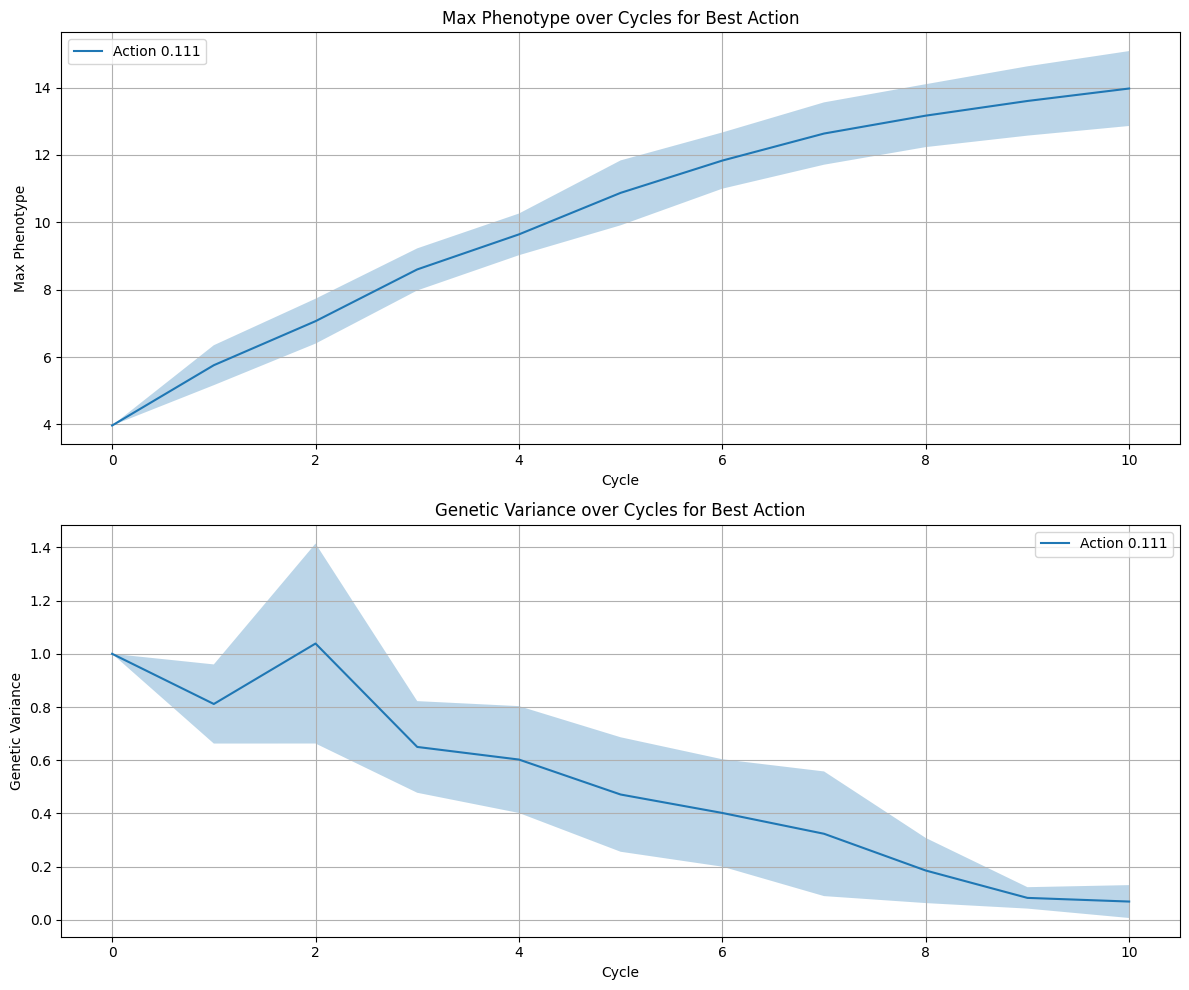

In [6]:

env = create_simulation(config)

    
# Usage remains the same
actions = np.linspace(-1, 1, 10)  # or however many actions you want to test
results, best_action, best_average = collect_baselines(env, actions, repetitions=10, cycles=config['end_gen'])

print(f"Best action: {best_action:.3f}")
print(f"Best average max phenotype in final generation: {best_average:.3f}")

# Plot the best run with both max phenotype and genetic variance
plot_best_run(results, best_action)

In [7]:
# FE = MultiScalarFeatureExtractor(env.observation_space)
# mock_observation = torch.tensor([[0.5,0.5,0.5,0.5,]], dtype=torch.float32)  # Single scalar input
# FE(mock_observation)

In [8]:
model = PPO(MultiScalarPolicy, env, verbose=1)
model.learn(total_timesteps=100)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | 7.37     |
| time/              |          |
|    fps             | 986      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


In [9]:
class CurriculumCallback(BaseCallback):
    def __init__(self, start_gen, end_gen, total_steps, verbose=1):
        super(CurriculumCallback, self).__init__(verbose)
        self.start_gen = start_gen
        self.end_gen = end_gen
        self.total_steps = total_steps
        self.current_max_gen = start_gen
        print(f"CurriculumCallback initialized: start_gen={start_gen}, end_gen={end_gen}, total_steps={total_steps}")

    def _on_training_start(self):
        print("Training started. CurriculumCallback is active.")

    def _on_step(self) -> bool:
        # Calculate the progress as a fraction of total steps
        progress = min(1.0, self.n_calls / self.total_steps)
        
        # Linearly interpolate between start_gen and end_gen based on progress
        new_max_gen = int(self.start_gen + progress * (self.end_gen - self.start_gen))
        
        if new_max_gen > self.current_max_gen:
            self.current_max_gen = new_max_gen
            try:
                self.training_env.env_method("update_max_generations", new_max_gen)
                print(f"Step {self.n_calls}: Updated max_generations to {new_max_gen}")
            except Exception as e:
                print(f"Error updating max_generations: {e}")
        
        if self.n_calls % 1000 == 0:  # Print debug info every 1000 steps
            print(f"Step {self.n_calls}: Current progress = {progress:.2f}, Current max_gen = {self.current_max_gen}")
        
        return True

    def on_training_end(self):
        print(f"Training ended. Final max_generations: {self.current_max_gen}")
        
        
class ActionTrackingCallback(BaseCallback):
    def __init__(self, log_freq=100, verbose=0):
        super(ActionTrackingCallback, self).__init__(verbose)
        self.log_freq = log_freq
        self.episode_count = 0
        self.action_history = defaultdict(list)
        self.current_episode_actions = []
        self.step_count = 0
        self.writer = None

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _on_step(self) -> bool:
        self.step_count += 1
        info = self.locals['infos'][0]
        action = self.locals['actions'][0]
        current_generation = info['current_generation']
        max_generations = self.training_env.get_attr('max_generations')[0]

        normalized_action = info['normalized_action']

        self.current_episode_actions.append((current_generation, normalized_action))

        if self.locals['dones'][0]:
            self.episode_count += 1
            for gen, action in self.current_episode_actions:
                self.action_history[gen].append(action)
            self.current_episode_actions = []

            if self.episode_count % self.log_freq == 0:
                self._log_action_data(max_generations)

        return True

    def _log_action_data(self, max_generations):
        for gen in range(max_generations):
            if gen in self.action_history:
                avg_action = np.mean(self.action_history[gen])
                self.writer.add_scalar(f"average_actions/generation_{gen}", avg_action, self.step_count)
        
        self.action_history.clear()

    def on_training_end(self):
        max_generations = self.training_env.get_attr('max_generations')[0]
        self._log_action_data(max_generations)
        if self.writer:
            self.writer.close()

In [39]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=500, plot_interval=500):
        super().__init__(verbose)
        self.log_interval = log_interval
        self.plot_interval = plot_interval
        self.step_counter = 0
        self.max_phenotype_buffer = []
        self.genetic_variance_buffer = []
        self.max_phenotype_history = []
        self.genetic_variance_history = []
        self.timesteps_history = []

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        self.max_phenotype_buffer.append(info['max_phenotype'])
        self.genetic_variance_buffer.append(info['genetic_variance'])
        self.step_counter += 1

        if self.step_counter % self.log_interval == 0:
            self.process_and_log_data()

        if self.num_timesteps % self.plot_interval == 0:
            self.update_plot()

        return True

    def process_and_log_data(self):
        max_phenotype = max(self.max_phenotype_buffer)
        mean_genetic_variance = sum(self.genetic_variance_buffer) / len(self.genetic_variance_buffer)

        self.max_phenotype_history.append(max_phenotype)
        self.genetic_variance_history.append(mean_genetic_variance)
        self.timesteps_history.append(self.num_timesteps)

        self.max_phenotype_buffer.clear()
        self.genetic_variance_buffer.clear()
        self.step_counter = 0

    def update_plot(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        
        plt.subplot(2, 1, 1)
        plt.plot(self.timesteps_history, self.max_phenotype_history)
        plt.title('Max Phenotype over Time')
        plt.xlabel('Timesteps')
        plt.ylabel('Max Phenotype')

        plt.subplot(2, 1, 2)
        plt.plot(self.timesteps_history, self.genetic_variance_history)
        plt.title('Genetic Variance over Time')
        plt.xlabel('Timesteps')
        plt.ylabel('Genetic Variance')

        plt.tight_layout()
        plt.show()

    def on_training_end(self):
        self.update_plot()  # Final plot

In [40]:
print(config['start_gen'],config['end_gen'])

2 10


In [41]:
config['total_timesteps']

2048

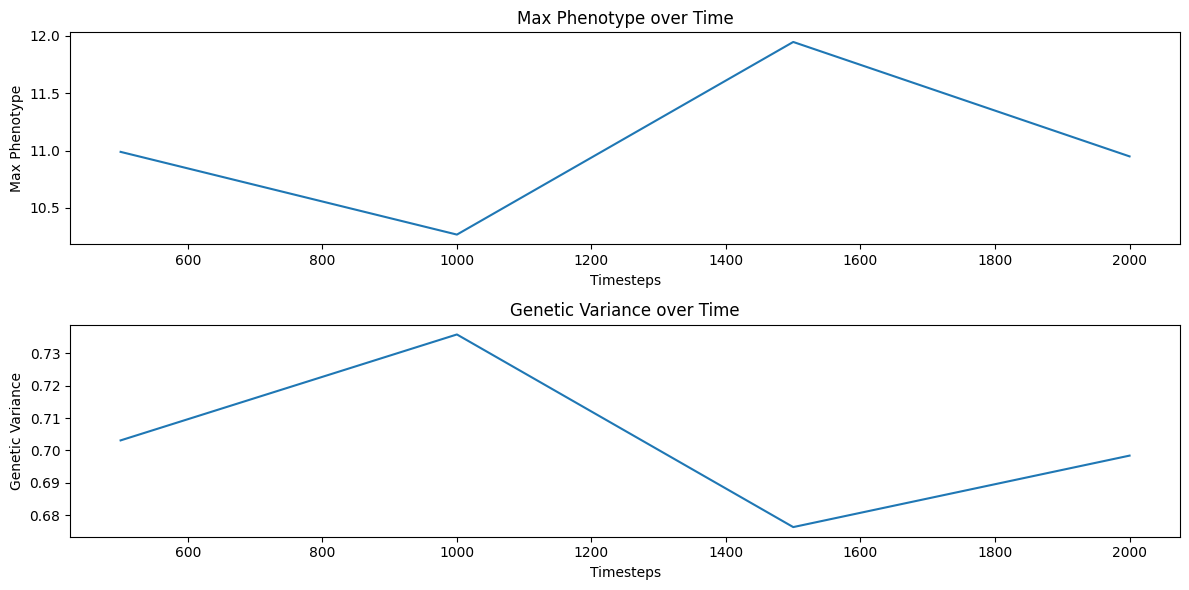

In [42]:
from collections import defaultdict

model = PPO(
    MultiScalarPolicy,
    env,
    verbose=1,
    tensorboard_log='../dev_nbs/ppotb'
)


# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

# Create your custom callbacks
custom_cb = CustomCallback()
# Combine the callbacks using CallbackList
model.learn(total_timesteps=config['total_timesteps'], callback=custom_cb)